In [1]:
# Usual ML imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# Keras stuff
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# OpenCV
import cv2

# Other modules
from pathlib import Path
from glob import glob

The dataset is included in the `data` folder. `tsrd-train` contains the images, while `TsignRecgTrain4170Annotation.txt` the annotations

In [2]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']

In [3]:
df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)
df.head()

,filename,width,height,x1,y1,x2,y2,label
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


Now let's just load some images with OpenCV, and draw on top of it the bounding box as described in the csv file

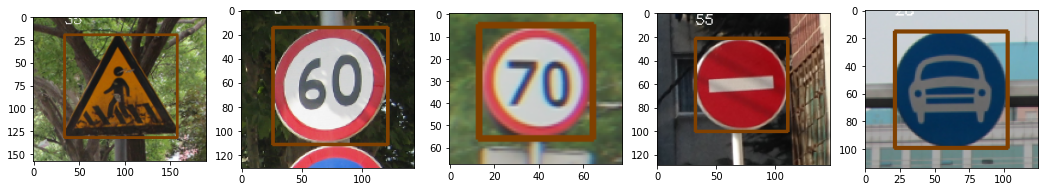

In [4]:
COLOR = (128, 64, 0)
COLOR_LABEL = (255, 255, 255)
THICKNESS = 2
index = 1

for _, row in df.sample(frac=1)[:5].iterrows():
    
    img_bgr = cv2.imread(str(Path(IMG_FOLDER / row.filename)))
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (row.x1, row.y1), (row.x2, row.y2), COLOR, THICKNESS)
    cv2.putText(img, str(row.label), (row.x1, row.y1 - 12), 0, 3*1e-3 * row.height, COLOR_LABEL, THICKNESS//2)
    plt.subplot(1, 5, index)
    index += 1
    plt.imshow(img)

Ok, we are now ready to create our dataset and save it on file. We will create the dataset containing the images (normalized between 0 and 1), store the labels and save it using numpy

In [5]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

for idx in range(len(images)):
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    img_bgr = cv2.imread(full_img_path)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = img_to_array(image)
    dataset.append(image)
    # get label specific to this image
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if row.empty:
        print(filename)
    else:
        labels.append(label)

In [6]:
dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

np.savez('../data/chinese_traffic_sign_dataset.npz', X=dataset, y=labels)